### This notebook retrieves data from projects.csv file and calculates values of project proportionality across different impact areas and presents the corresponding graph. This file also plots the performance of City Idea Project and Green Million projects against the expected Equal Shares performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative


In [6]:
# Shows that there are 70 winning projects whose budget percent is 100%, uses the total budget
full_budget_winners_projects = pbprojects_df[(pbprojects_df['budget_percent'] == 100) & ((pbprojects_df['is_greedy_winner'] == True) | (pbprojects_df['is_mes_winner'] == True))]
print(full_budget_winners_projects.shape)
print(full_budget_winners_projects['election_id'].unique())
test_df = full_budget_winners_projects[(full_budget_winners_projects['is_mes_winner'] == True) & (full_budget_winners_projects['is_greedy_winner'] == False)]
test_df.shape


(98, 22)
[ 20  21  25  26  30  31  32  35  36  38  40  42  43  44  45  46  47  48
  51  52  55  56  58  60  66  70  72  80  82  94 100 251 258 260 313 330
 423 460 465 557 682 684 688 690 692 694 696 698 700 704 706 708 717 719
 721 723 725 727 729 731 733 735 737 741 743 745 747 749 753 755 757 759
 761 763 765 767 774 776 777 778 779 783 785 786 788 790 791 793 794 795
 798 799 801 805 807 809 810 811]


(0, 22)

In [7]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
    project_id  election_id
893          5           72
(19110, 22)
(19109, 22)


In [8]:
print("Subunit empty projects count: ", valid_pbprojects_df['subunit'].isna().sum())

empty_subunit_projects_df = valid_pbprojects_df[valid_pbprojects_df['subunit'].isna()][['election_id','project_id']]
print(empty_subunit_projects_df.shape)
print(empty_subunit_projects_df['election_id'].nunique())

# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)
print("Valid PB projects are: ", valid_pbprojects_df.shape)

Subunit empty projects count:  1928
(1928, 2)
25
(1928, 22)
Valid PB projects are:  (19109, 22)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\660040707.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [9]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [10]:
# Election ids of city idea and green million
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
aarau_election_id = aarau_election_id.values[0]

green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = green_budget_election_id.values[0]

In [11]:
print("Distinct election IDs are: ", valid_pbprojects_df['election_id'].nunique())
valid_pbprojects_df_grouped_election = valid_pbprojects_df.groupby(['election_id','is_mes_winner'])['cost'].agg(['sum']).reset_index()
print(valid_pbprojects_df_grouped_election.head())
print(valid_pbprojects_df_grouped_election.shape)
print("Unique election IDs after grouping total costs: ", valid_pbprojects_df_grouped_election['election_id'].nunique())
mes_winners_grouped_project_count = valid_pbprojects_df_grouped_election[valid_pbprojects_df_grouped_election['is_mes_winner'] == True]
print(mes_winners_grouped_project_count.shape)

Distinct election IDs are:  812
   election_id  is_mes_winner       sum
0            1          False   1455000
1            1           True    997000
2            2          False  23588713
3            2           True   2350560
4            3          False    804294
(1563, 3)
Unique election IDs after grouping total costs:  812
(812, 3)


In [12]:
# setting additional column for used budget with MES aggregation
print(valid_pbprojects_df.shape)

elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]
print("Elections with MES winners: ", elections_with_mes_winners['election_id'].nunique())
print("Elections with Greedy Winners: ", elections_with_greedy_winners['election_id'].nunique())

# Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 24)
Elections with MES winners:  812
Elections with Greedy Winners:  812
(19109, 26)


In [13]:
valid_pbprojects_df.dtypes

election_id                   int64
country                      object
unit                         object
subunit                      object
instance                      int64
project_id                   object
cost                          int64
project_voters_count          int64
votes                         int64
score                       float64
category                     object
name                         object
englishName                 float64
target                       object
total_budget                float64
budget_percent              float64
is_mes_winner                  bool
is_greedy_winner               bool
is_phragmen_winner             bool
latitude                    float64
longitude                   float64
vote_type                    object
total_votes_selection         int64
vote_percent                float64
mes_total_budget_usage        int64
mes_budget_usage_percent    float64
dtype: object

In [14]:
# Getting the total budget usage for utilitarian greedy winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_greedy_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner']].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_greedy_budget_usage.rename(columns={'cost': 'greedy_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_greedy_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['greedy_budget_usage_percent'] = round((valid_pbprojects_df['greedy_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 28)


## Fill empty values for category with the label 'uncategorized' to aid in further data analysis

In [15]:
valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


## The column `category` contains multiple categories embedded into the column separated by commas, let's do some data processing so that we select only first signifiying category
## We store this into a new column called `major_category`

In [16]:
def trimCategoryText(category_text):
    return category_text.split(',')[0]

valid_pbprojects_df['major_category'] = valid_pbprojects_df['category'].apply(trimCategoryText)
valid_pbprojects_df['major_category'].nunique()

print("Empty major category: ", valid_pbprojects_df['major_category'].isna().sum())
print("---------------------------------------------------------------")
print("Counts for each major category: \n", valid_pbprojects_df['major_category'].value_counts())
print("---------------------------------------------------------------")
print("Major categories sum: ", valid_pbprojects_df['major_category'].value_counts().sum())



Empty major category:  0
---------------------------------------------------------------
Counts for each major category: 
 major_category
uncategorized               8182
education                   2435
public space                2058
urban greenery              1491
sport                       1296
public transit and roads    1240
culture                     1125
environmental protection     722
welfare                      322
health                       238
Name: count, dtype: int64
---------------------------------------------------------------
Major categories sum:  19109


## Create additional columns for each category label

In [17]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

valid_pbprojects_df.tail()

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,total_votes_selection,vote_percent,mes_total_budget_usage,mes_budget_usage_percent,greedy_total_budget_usage,greedy_budget_usage_percent,major_category,category_public transit and roads,category_urban greenery,category_education,category_public space,category_welfare,category_uncategorized,category_sport,category_health,category_environmental protection,category_culture,category_labels_count
19104,1000,Switzerland,Aaurau,Aaurau,2023,18,5000,1703,88,146.0000,health,Project18,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,8262,1.0650,49100,98.2000,49600,99.2000,health,0,0,0,0,0,0,0,1,0,0,1.0000
19105,1000,Switzerland,Aaurau,Aaurau,2023,17,3500,1703,67,102.0000,welfare,Project17,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,8262,0.8110,49100,98.2000,49600,99.2000,welfare,0,0,0,0,1,0,0,0,0,0,1.0000
19106,1000,Switzerland,Aaurau,Aaurau,2023,27,4000,1703,69,97.0000,welfare,Project27,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.8350,49100,98.2000,49600,99.2000,welfare,0,0,0,0,1,0,0,0,0,0,1.0000
19107,1000,Switzerland,Aaurau,Aaurau,2023,19,500,1703,56,85.0000,welfare,Project19,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,8262,0.6780,49100,98.2000,49600,99.2000,welfare,0,0,0,0,1,0,0,0,0,0,1.0000
19108,1000,Switzerland,Aaurau,Aaurau,2023,6,4000,1703,44,85.0000,welfare,Project6,NaN,"youth,adults,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.5330,49100,98.2000,49600,99.2000,welfare,0,0,0,0,1,0,0,0,0,0,1.0000


<font color="green"> Not sure if the above data is useful currently, but I will keep the data just in case, the dataset turns out to be useful for later cases </font>

## Check to see if there are other labelled categories there were in between the commas but not in the major categories. This is not at a single project level, but the entire dataset level

In [18]:
major_categories_list = valid_pbprojects_df['major_category'].unique().tolist()
print(major_categories_list)
unlisted_minor_categories = []

for idx, row in valid_pbprojects_df.iterrows():
    category_text = row['category']
    cat_list = category_text.split(',')
    for item in cat_list:
        if item not in major_categories_list:
            unlisted_minor_categories.append(item)


print("Unlisted minor categories: ", unlisted_minor_categories)


['uncategorized', 'public transit and roads', 'public space', 'education', 'culture', 'sport', 'environmental protection', 'health', 'welfare', 'urban greenery']
Unlisted minor categories:  []


<font color="green">
<h5>The above value of empty unlisted minor categories means that it is sufficient to take note of the major categories only</h5>
</font>

## For each instance of PB normalize project costs with min-max normalization

In [19]:
instance_grouped_max_pbprojects_df = valid_pbprojects_df.groupby(['election_id'])['cost'].max().reset_index()
instance_grouped_max_pbprojects_df.rename(columns={'cost': 'election_project_max_cost'}, inplace=True)

instance_grouped_min_pbprojects_df = valid_pbprojects_df.groupby(['election_id'])['cost'].min().reset_index()
instance_grouped_min_pbprojects_df.rename(columns={'cost': 'election_project_min_cost'}, inplace=True)

instance_grouped_total_projects_cost_df = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
instance_grouped_total_projects_cost_df.rename(columns={'cost': 'total_projects_cost'}, inplace=True)

print("Valid PB Projects Shape before merge: ", valid_pbprojects_df.shape)
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_max_pbprojects_df, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_min_pbprojects_df, on='election_id', how='inner')
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_total_projects_cost_df, on='election_id', how='inner')
print("After merge: ", valid_pbprojects_df.shape)

def applyMinMaxNormalization(row):
    if ((row['cost'] == row['election_project_max_cost']) & (row['cost'] == row['election_project_min_cost'])):
        return 0.5
    else:
        return ((row['cost'] - row['election_project_min_cost']) / (row['election_project_max_cost'] - row['election_project_min_cost']))

valid_pbprojects_df['normalized_cost'] = valid_pbprojects_df.apply(lambda row: applyMinMaxNormalization(row), axis=1)


Valid PB Projects Shape before merge:  (19109, 40)
After merge:  (19109, 43)


## Calculate average normalized cost of entire pb instance, only greedy winners of instance, only mes winners of pb instance and so on

In [20]:
# Group valid_pbprojects_df and create a new dataframe for each grouped average results
instance_overall_avg_cost = valid_pbprojects_df.groupby(['election_id'])['normalized_cost'].mean().reset_index()
instance_overall_avg_cost.rename(columns={'normalized_cost': 'normalized_overall_avg_cost'}, inplace=True)

instance_greedy_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_greedy_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_greedy_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_avg_cost.merge(instance_greedy_winner_avg_cost, on='election_id', how='inner')


instance_mes_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_mes_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_mes_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_mes_winner_avg_cost, on='election_id', how='inner')

instance_either_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] ==True) | (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_either_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_either_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_either_winner_avg_cost, on='election_id', how='inner')

instance_neither_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_neither_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_neither_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_neither_winner_avg_cost, on='election_id', how='left')

instance_both_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_both_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_both_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_both_winner_avg_cost, on='election_id', how='left')

instance_only_greedy_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_only_greedy_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_only_greedy_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_only_greedy_winner_avg_cost, on='election_id', how='left')

instance_only_mes_winner_avg_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby('election_id')['normalized_cost'].mean().reset_index()
instance_only_mes_winner_avg_cost.rename(columns={'normalized_cost': 'normalized_only_mes_avg_cost'}, inplace=True)
instance_overall_df = instance_overall_df.merge(instance_only_mes_winner_avg_cost, on='election_id', how='left')

# Fill non-existent values for instance_overall_df with values equal to -1. -1 because we had already normalized values between 0 and 1
instance_overall_df.fillna(-1, inplace=True)
print(instance_overall_df.shape)

(812, 9)


In [21]:
categorization_df = valid_pbprojects_df
categorization_df = categorization_df[[
       'election_id', 'unit', 'subunit', 'instance', 'project_id', 'cost', 'target', 'total_projects_cost', 'votes', 'score', 'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'category', 'category_public transit and roads',
       'category_health', 'category_welfare', 'category_uncategorized',
       'category_public space', 'category_urban greenery', 'category_culture',
       'category_education', 'category_sport',
       'category_environmental protection', 'category_labels_count'
]]
categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)


# In my earlier logic, I had put uncategorized to each undefined project categorization, however, this did not increase the total category counts. 
# So using this, we can the filter to remove uncategorized pb instances where uncategorized value is gre
# ater than 0
# Also, accordingly, uncategorized > 0 and total count values > 0 must not exists; sanity check
empty_df = categorization_df[(categorization_df['uncategorized'] > 0) & (categorization_df['total_tags'] > 0)]
print("Size of returned df must be 0: ", empty_df.shape)

# Apply an additional filter to remove uncategorized values from the categorization_df
print("Before applying filter shape of categorization DF is: ", categorization_df.shape)
categorization_df = categorization_df[categorization_df['uncategorized'] == 0]
print("After filtering, shape of categorization_df is: ", categorization_df.shape)
## The output shape of 10830 x 22, matches with valid_pbprojects_df rows having major_category values other than `uncategorized`
# So our data filtering is correct



# Taking the sum of each category after having goruped by election id for mes_winners and rename the columns
mes_winners_grouped_categorization_df = categorization_df[categorization_df['is_mes_winner'] == True].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()
only_mes_winners_grouped_categorization_df = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()

greedy_winners_grouped_categorization_df = categorization_df[categorization_df['is_greedy_winner'] == True].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()
only_greedy_winners_grouped_categorization_df = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()

# Apply filters to remove PB instances that have uncategorized datasets
# Group by election IDs and sum the values of each category. If an instance has no values of the summed values in either categories, those are to be removed as uncategorized

mes_winners_grouped_categorization_df


# Create columns to store selection of percentages
def addPercentageColumns(df):
       categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

       # Create new columns for percentage values
       for category in categories_set:
              df[f'percentage_{category}'] = (df[category] / df['total_tags']) * 100

# Apply the addPercentageColumns for each of the above 4 dataframes
addPercentageColumns(mes_winners_grouped_categorization_df)
addPercentageColumns(only_mes_winners_grouped_categorization_df)
addPercentageColumns(greedy_winners_grouped_categorization_df)
addPercentageColumns(only_greedy_winners_grouped_categorization_df)

print(mes_winners_grouped_categorization_df.shape)

pb_instance_with_labels = valid_pbprojects_df[valid_pbprojects_df['major_category'] != 'uncategorized'].groupby('election_id').count()
print("PB instances with valid labels: ", pb_instance_with_labels.shape)
# The row value from the above shape matches with the MES winners and Greedy winners after grouping

mes_winners_grouped_categorization_df = mes_winners_grouped_categorization_df.add_prefix('mes_')
greedy_winners_grouped_categorization_df = greedy_winners_grouped_categorization_df.add_prefix('greedy_')

only_greedy_winners_grouped_categorization_df = only_greedy_winners_grouped_categorization_df.add_prefix('only_greedy_')
only_mes_winners_grouped_categorization_df = only_mes_winners_grouped_categorization_df.add_prefix('only_mes_')

winners_grouped_categorization_df = mes_winners_grouped_categorization_df.merge(greedy_winners_grouped_categorization_df, how='inner', on='election_id')

# because only greedy has one more row (election instance) than only mes, verified by the code block below
exclusive_winners_grouped_categorization_df = only_greedy_winners_grouped_categorization_df.merge(only_mes_winners_grouped_categorization_df, how='inner', on='election_id')

# Verification to find the commonalities between only_mes and only_greedy grouped instances; uncomment to check!
'''
valid_only_mes_winners_election_ids = set(only_mes_winners_grouped_categorization_df.index.unique().to_list())
valid_only_greedy_winners_election_ids = set(only_greedy_winners_grouped_categorization_df.index.unique().to_list())

common_elections_count = len(valid_only_greedy_winners_election_ids.difference(valid_only_mes_winners_election_ids))
print(common_elections_count)
'''

print(winners_grouped_categorization_df.shape)
print(exclusive_winners_grouped_categorization_df.shape)

Size of returned df must be 0:  (0, 25)
Before applying filter shape of categorization DF is:  (19109, 25)
After filtering, shape of categorization_df is:  (10927, 25)
(346, 21)
PB instances with valid labels:  (346, 43)
(346, 42)
(278, 42)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2466628273.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)


In [22]:
# Concat works here to merge the winners grouped data and exclusive winners data, because they share the common index
grouped_categorization_df = pd.concat([winners_grouped_categorization_df, exclusive_winners_grouped_categorization_df], axis=1)
print(grouped_categorization_df.shape)
grouped_categorization_df

# drop uncategorized and their respective % columns from the dataset, because they are all zero, since we filtered out uncategorized data earlier
grouped_categorization_df.drop(columns=['mes_uncategorized', 'mes_percentage_uncategorized', 'greedy_uncategorized', 'greedy_percentage_uncategorized', 'only_mes_uncategorized', 'only_mes_percentage_uncategorized', 'only_greedy_uncategorized', 'only_greedy_percentage_uncategorized'], inplace=True)
print("After dropping, new shape is: ", grouped_categorization_df.shape)

(346, 84)
After dropping, new shape is:  (346, 76)


## Create sorted ordering for the 344 PB instances with their % values of winnings in each category for MES and Greedy

In [23]:
# some globals to be used for the code snippets below
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [0,2],
    3: [1,0],
    4: [1,1],
    5: [1,2],
    6: [2,0],
    7: [2,1],
    8: [2,2]
}

In [24]:
grouped_categorization_df['diff_pct_education'] = grouped_categorization_df['greedy_percentage_education'] - grouped_categorization_df['mes_percentage_education'] 
grouped_categorization_df['diff_pct_health'] = grouped_categorization_df['greedy_percentage_health'] - grouped_categorization_df['mes_percentage_health']
grouped_categorization_df['diff_pct_welfare'] = grouped_categorization_df['greedy_percentage_welfare'] - grouped_categorization_df['mes_percentage_welfare']
grouped_categorization_df['diff_pct_sport'] = grouped_categorization_df['greedy_percentage_sport'] - grouped_categorization_df['mes_percentage_sport']
grouped_categorization_df['diff_pct_public_space'] = grouped_categorization_df['greedy_percentage_public_space'] - grouped_categorization_df['mes_percentage_public_space']
grouped_categorization_df['diff_pct_public_transit_and_roads'] = grouped_categorization_df['greedy_percentage_public_transit_and_roads'] - grouped_categorization_df['mes_percentage_public_transit_and_roads']
grouped_categorization_df['diff_pct_env_protection'] = grouped_categorization_df['greedy_percentage_env_protection'] - grouped_categorization_df['mes_percentage_env_protection']
grouped_categorization_df['diff_pct_culture'] = grouped_categorization_df['greedy_percentage_culture'] - grouped_categorization_df['mes_percentage_culture']
grouped_categorization_df['diff_pct_urban_greenery'] = grouped_categorization_df['greedy_percentage_urban_greenery'] - grouped_categorization_df['mes_percentage_urban_greenery']

grouped_categorization_df['only_diff_pct_education'] = grouped_categorization_df['only_greedy_percentage_education'] - grouped_categorization_df['only_mes_percentage_education'] 
grouped_categorization_df['only_diff_pct_health'] = grouped_categorization_df['only_greedy_percentage_health'] - grouped_categorization_df['only_mes_percentage_health']
grouped_categorization_df['only_diff_pct_welfare'] = grouped_categorization_df['only_greedy_percentage_welfare'] - grouped_categorization_df['only_mes_percentage_welfare']
grouped_categorization_df['only_diff_pct_sport'] = grouped_categorization_df['only_greedy_percentage_sport'] - grouped_categorization_df['only_mes_percentage_sport']
grouped_categorization_df['only_diff_pct_public_space'] = grouped_categorization_df['only_greedy_percentage_public_space'] - grouped_categorization_df['only_mes_percentage_public_space']
grouped_categorization_df['only_diff_pct_public_transit_and_roads'] = grouped_categorization_df['only_greedy_percentage_public_transit_and_roads'] - grouped_categorization_df['only_mes_percentage_public_transit_and_roads']
grouped_categorization_df['only_diff_pct_env_protection'] = grouped_categorization_df['only_greedy_percentage_env_protection'] - grouped_categorization_df['only_mes_percentage_env_protection']
grouped_categorization_df['only_diff_pct_culture'] = grouped_categorization_df['only_greedy_percentage_culture'] - grouped_categorization_df['only_mes_percentage_culture']
grouped_categorization_df['only_diff_pct_urban_greenery'] = grouped_categorization_df['only_greedy_percentage_urban_greenery'] - grouped_categorization_df['only_mes_percentage_urban_greenery']


grouped_categorization_df_na_removed = grouped_categorization_df.dropna()

# Check the output of two different values just for confirmation
# grouped_categorization_df[['mes_percentage_health', 'greedy_percentage_health', 'diff_pct_health', 'only_diff_pct_education', 'only_greedy_percentage_education', 'only_mes_percentage_education']]

## Use the categorization_df dataframe as a base and add new metrics necessary for calculating cost utilization and relative winners for each category of each PB instance

In [25]:
print("Shape of categorization_df : ", categorization_df.shape)

# for each category; add columns that signify the total cost of each category per PB instance
# Create columns to store selection of percentages
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_total_cost'].fillna(0, inplace=True)

Shape of categorization_df :  (10927, 25)


In [26]:
# Add 4 columns that denote; MES Winners Projects Count, MES Winners Project Costs, Greedy Winners Projects Count and Greedy Winners Project Cost; (overall)
election_grouped_mes_winners_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_mes_winners_total_cost.rename(columns={'cost': 'mes_winners_total_cost'}, inplace=True)

election_grouped_greedy_winners_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_greedy_winners_total_cost.rename(columns={'cost': 'greedy_winners_total_cost'}, inplace=True)

election_grouped_mes_winners_total_project_count = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_mes_winners_total_project_count.rename(columns={'project_id': 'mes_winners_projects_count'}, inplace=True)

election_grouped_greedy_winners_total_project_count = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_greedy_winners_total_project_count.rename(columns={'project_id': 'greedy_winners_projects_count'}, inplace=True)

# Merge these dataset with categorization_df
categorization_df = categorization_df.merge(election_grouped_mes_winners_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_greedy_winners_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_mes_winners_total_project_count, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_greedy_winners_total_project_count, on='election_id', how='inner')

In [27]:
# Add another 4 columns that denote; only MES Winners Projects Count, only MES Winners Project Costs, only Greedy Winners Projects Count and only Greedy Winners Project Cost; (overall)
election_grouped_only_mes_winners_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_only_mes_winners_total_cost.rename(columns={'cost': 'only_mes_winners_total_cost'}, inplace=True)

election_grouped_only_greedy_winners_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_only_greedy_winners_total_cost.rename(columns={'cost': 'only_greedy_winners_total_cost'}, inplace=True)

election_grouped_only_mes_winners_total_project_count = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_only_mes_winners_total_project_count.rename(columns={'project_id': 'only_mes_winners_projects_count'}, inplace=True)

election_grouped_only_greedy_winners_total_project_count = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_only_greedy_winners_total_project_count.rename(columns={'project_id': 'only_greedy_winners_projects_count'}, inplace=True)

# Merge these dataset with categorization_df; for only, we will need to use left join, because there can be cases where
# both outcomes are the same, in such cases only values don't exist; so left join is needed
categorization_df = categorization_df.merge(election_grouped_only_mes_winners_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_greedy_winners_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_mes_winners_total_project_count, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_greedy_winners_total_project_count, on='election_id', how='left')

In [28]:
# Merge categorization_df with pbsummary to get total projects in all elections
pbsummary_num_votes = pbsummary_df[['election_id', 'num_projects']]
categorization_df = categorization_df.merge(pbsummary_num_votes, on='election_id', how='inner')
categorization_df

,election_id,unit,subunit,instance,project_id,cost,target,total_projects_cost,votes,score,is_mes_winner,is_greedy_winner,is_phragmen_winner,category,public_transit_and_roads,health,welfare,uncategorized,public_space,urban_greenery,culture,education,sport,env_protection,total_tags,education_total_cost,public_transit_and_roads_total_cost,health_total_cost,welfare_total_cost,public_space_total_cost,urban_greenery_total_cost,culture_total_cost,sport_total_cost,env_protection_total_cost,mes_winners_total_cost,greedy_winners_total_cost,mes_winners_projects_count,greedy_winners_projects_count,only_mes_winners_total_cost,only_greedy_winners_total_cost,only_mes_winners_projects_count,only_greedy_winners_projects_count,num_projects
0,332,Warszawa,Aleksandrów,2017,261,80000,"adults,families with children",287217,172,NaN,False,True,False,"public transit and roads,public space",1,0,0,0,1,0,0,0,0,0,2.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
1,332,Warszawa,Aleksandrów,2017,1112,99267,"adults,seniors,families with children",287217,140,NaN,False,False,False,public transit and roads,1,0,0,0,0,0,0,0,0,0,1.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
2,332,Warszawa,Aleksandrów,2017,720,30000,NaN,287217,118,NaN,True,True,True,"public space,education,culture",0,0,0,0,1,0,1,1,0,0,3.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
3,332,Warszawa,Aleksandrów,2017,1206,9200,"adults,seniors",287217,99,NaN,True,False,True,"education,sport",0,0,0,0,0,0,0,1,1,0,2.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
4,332,Warszawa,Aleksandrów,2017,2592,68750,"children,youth,adults",287217,86,NaN,True,False,True,public transit and roads,1,0,0,0,0,0,0,0,0,0,1.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10922,1000,Aaurau,Aaurau,2023,18,5000,"adults,families with children",247030,88,146.0000,False,False,False,health,0,1,0,0,0,0,0,0,0,0,1.0000,10000.0000,4000.0000,5000.0000,56530.0000,0.0000,75300.0000,25000.0000,19300.0000,51900.0000,49100,49600,17,7,29500.0000,30000.0000,12.0000,2.0000,33
10923,1000,Aaurau,Aaurau,2023,17,3500,elderly,247030,67,102.0000,False,False,False,welfare,0,0,1,0,0,0,0,0,0,0,1.0000,10000.0000,4000.0000,5000.0000,56530.0000,0.0000,75300.0000,25000.0000,19300.0000,51900.0000,49100,49600,17,7,29500.0000,30000.0000,12.0000,2.0000,33
10924,1000,Aaurau,Aaurau,2023,27,4000,"children,families with children,elderly",247030,69,97.0000,False,False,False,welfare,0,0,1,0,0,0,0,0,0,0,1.0000,10000.0000,4000.0000,5000.0000,56530.0000,0.0000,75300.0000,25000.0000,19300.0000,51900.0000,49100,49600,17,7,29500.0000,30000.0000,12.0000,2.0000,33
10925,1000,Aaurau,Aaurau,2023,19,500,"youth,adults,elderly",247030,56,85.0000,True,False,True,welfare,0,0,1,0,0,0,0,0,0,0,1.0000,10000.0000,4000.0000,5000.0000,56530.0000,0.0000,75300.0000,25000.0000,19300.0000,51900.0000,49100,49600,17,7,29500.0000,30000.0000,12.0000,2.0000,33


In [29]:
# Adding total cost of each category in each election for greedy winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    greedy_winners_category_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    greedy_winners_category_grouped_df.rename(columns={'cost': f'greedy_winners_{category}_total_cost'}, inplace=True)
    
    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(greedy_winners_category_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'greedy_winners_{category}_total_cost'].fillna(0, inplace=True)

# Adding total cost of each category in each election for MES winners
for category in categories_set:
    # temporarily grouped df 
    mes_winners_category_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    mes_winners_category_grouped_df.rename(columns={'cost': f'mes_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(mes_winners_category_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'mes_winners_{category}_total_cost'].fillna(0, inplace=True)


In [30]:
# Project counts in each category; just overall, not winners in any sense
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_projects_count'].fillna(0, inplace=True)

In [31]:
# Project counts in each category that are Greedy winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'greedy_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'greedy_winners_{category}_projects_count'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'mes_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'mes_winners_{category}_projects_count'].fillna(0, inplace=True)

In [32]:
# Project counts in each category that are Greedy winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'only_greedy_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_greedy_winners_{category}_projects_count'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'only_mes_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_mes_winners_{category}_projects_count'].fillna(0, inplace=True)

In [33]:
# Project counts in each category that are Greedy winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'only_greedy_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_greedy_winners_{category}_total_cost'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'only_mes_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_mes_winners_{category}_total_cost'].fillna(0, inplace=True)

##  Metrics for Budget Share and Winning Rate

In [34]:
# metrics calculation required for relative winners
print("Current shape of categorization df is: ", categorization_df.shape)

for category in categories_set:
    categorization_df[f'greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df['greedy_winners_total_cost']
    categorization_df[f'mes_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / categorization_df['mes_winners_total_cost']
    categorization_df[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] - categorization_df[f'mes_relative_winners_cost_pct_{category}']

    categorization_df[f'greedy_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_projects_count'] / categorization_df['greedy_winners_projects_count']
    categorization_df[f'mes_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_projects_count'] / categorization_df['mes_winners_projects_count']
    categorization_df[f'diff_greedy_mes_relative_winners_count_pct_{category}'] = categorization_df[f'greedy_relative_winners_count_pct_{category}'] - categorization_df[f'mes_relative_winners_count_pct_{category}']
    
    categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_total_cost'] / categorization_df['only_greedy_winners_total_cost']
    categorization_df[f'only_mes_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_total_cost'] / categorization_df['only_mes_winners_total_cost']
    categorization_df[f'diff_go_mo_relative_winners_cost_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] - categorization_df[f'only_mes_relative_winners_cost_pct_{category}']

    categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_projects_count'] / categorization_df[f'only_greedy_winners_projects_count']
    categorization_df[f'only_mes_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_projects_count'] / categorization_df[f'only_mes_winners_projects_count']
    categorization_df[f'diff_go_mo_relative_winners_count_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] - categorization_df[f'only_mes_relative_winners_count_pct_{category}']

print("After adding new columns, shape should increase by 108 cols: ", categorization_df.shape)

Current shape of categorization df is:  (10927, 124)
After adding new columns, shape should increase by 108 cols:  (10927, 232)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\3749671010.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'diff_go_mo_relative_winners_count_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] - categorization_df[f'only_mes_relative_winners_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\3749671010.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df

In [35]:
# additional metrics for average; relative winners cost / number
for category in categories_set:
    categorization_df[f'greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'greedy_relative_winners_count_pct_{category}']
    categorization_df[f'mes_relative_winners_avg_cost_{category}'] = categorization_df[f'mes_relative_winners_cost_pct_{category}'] / categorization_df[f'mes_relative_winners_count_pct_{category}']
    categorization_df[f'diff_ug_mes_relative_winners_avg_cost_{category}'] = categorization_df[f'greedy_relative_winners_avg_cost_{category}'] - categorization_df[f'mes_relative_winners_avg_cost_{category}'] 

    categorization_df[f'only_greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'only_greedy_relative_winners_count_pct_{category}']
    categorization_df[f'only_mes_relative_winners_avg_cost_{category}'] = categorization_df[f'only_mes_relative_winners_cost_pct_{category}'] / categorization_df[f'only_mes_relative_winners_count_pct_{category}']
    categorization_df[f'diff_go_mo_relative_winners_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_winners_avg_cost_{category}'] - categorization_df[f'only_mes_relative_winners_avg_cost_{category}'] 

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\1702093023.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'greedy_relative_winners_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\1702093023.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_winners_avg_cost_{category}'] = categorization_df[f'mes_relative_winne

## Metrics for Cost and Project Representation

In [36]:
# New metrics required relative proposals in each category
print("Before adding new metrics, shape was: ", categorization_df.shape)
for category in categories_set:
    categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] - categorization_df[f'mes_relative_proposals_cost_pct_{category}']
    
    categorization_df[f'greedy_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'mes_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] = categorization_df[f'greedy_relative_proposals_count_pct_{category}'] - categorization_df[f'mes_relative_proposals_count_pct_{category}']
    
    categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'only_mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'diff_go_mo_relative_proposals_cost_pct_{category}'] = categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] - categorization_df[f'only_mes_relative_proposals_cost_pct_{category}']

    categorization_df[f'only_greedy_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'only_mes_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'diff_go_mo_relative_proposals_count_pct_{category}'] = categorization_df[f'only_greedy_relative_proposals_count_pct_{category}'] - categorization_df[f'only_mes_relative_proposals_count_pct_{category}']

print("After adding new columns, shape should increase by 108 cols: ", categorization_df.shape)


Before adding new metrics, shape was:  (10927, 286)
After adding new columns, shape should increase by 108 cols:  (10927, 394)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\320176274.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\320176274.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / 

In [37]:
# additional metrics for average of relative proposals
for category in categories_set:
    categorization_df[f'greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'greedy_relative_proposals_count_pct_{category}']
    categorization_df[f'mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'mes_relative_proposals_cost_pct_{category}'] / categorization_df[f'mes_relative_proposals_count_pct_{category}']
    categorization_df[f'diff_ug_mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'greedy_relative_proposals_avg_cost_{category}'] - categorization_df[f'mes_relative_proposals_avg_cost_{category}'] 

    categorization_df[f'only_greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'only_greedy_relative_proposals_count_pct_{category}']
    categorization_df[f'only_mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'only_mes_relative_proposals_cost_pct_{category}'] / categorization_df[f'only_mes_relative_proposals_count_pct_{category}']
    categorization_df[f'diff_go_mo_relative_proposals_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_proposals_avg_cost_{category}'] - categorization_df[f'only_mes_relative_proposals_avg_cost_{category}'] 

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\666939267.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'greedy_relative_proposals_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\666939267.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'mes_relative

## Metrics for Cost and Project Proportionality

In [38]:
# Forming the metrics required for calculation
print("Shape of categorization_df before adding metrics: ", categorization_df.shape)
for category in categories_set:
    categorization_df[f'greedy_rr_cost_{category}'] = (categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df['greedy_winners_total_cost']) / (categorization_df[f'{category}_total_cost'] / categorization_df['total_projects_cost'])
    categorization_df[f'mes_rr_cost_{category}'] = (categorization_df[f'mes_winners_{category}_total_cost'] / categorization_df['mes_winners_total_cost']) / (categorization_df[f'{category}_total_cost'] / categorization_df['total_projects_cost'])
    categorization_df[f'diff_greedy_mes_rr_cost_{category}'] = categorization_df[f'greedy_rr_cost_{category}'] - categorization_df[f'mes_rr_cost_{category}']

    categorization_df[f'greedy_rr_projects_count_{category}'] = (categorization_df[f'greedy_winners_{category}_projects_count'] / categorization_df['greedy_winners_projects_count']) / (categorization_df[f'{category}_projects_count'] / categorization_df['num_projects'])
    categorization_df[f'mes_rr_projects_count_{category}'] = (categorization_df[f'mes_winners_{category}_projects_count'] / categorization_df['mes_winners_projects_count']) / (categorization_df[f'{category}_projects_count'] / categorization_df['num_projects'])
    categorization_df[f'diff_greedy_mes_rr_projects_count_{category}'] = categorization_df[f'greedy_rr_projects_count_{category}'] - categorization_df[f'mes_rr_projects_count_{category}']

    categorization_df[f'only_greedy_rr_cost_{category}'] = (categorization_df[f'only_greedy_winners_{category}_total_cost'] / categorization_df['only_greedy_winners_total_cost']) / (categorization_df[f'{category}_total_cost'] / categorization_df['total_projects_cost'])
    categorization_df[f'only_mes_rr_cost_{category}'] = (categorization_df[f'only_mes_winners_{category}_total_cost'] / categorization_df['only_mes_winners_total_cost']) / (categorization_df[f'{category}_total_cost'] / categorization_df['total_projects_cost'])
    categorization_df[f'diff_go_mo_rr_cost_{category}'] = categorization_df[f'only_greedy_rr_cost_{category}'] - categorization_df[f'only_mes_rr_cost_{category}']

    categorization_df[f'only_greedy_rr_projects_count_{category}'] = (categorization_df[f'only_greedy_winners_{category}_projects_count'] / categorization_df['only_greedy_winners_projects_count']) / (categorization_df[f'{category}_projects_count'] / categorization_df['num_projects'])
    categorization_df[f'only_mes_rr_projects_count_{category}'] = (categorization_df[f'only_mes_winners_{category}_projects_count'] / categorization_df['only_mes_winners_projects_count']) / (categorization_df[f'{category}_projects_count'] / categorization_df['num_projects'])
    categorization_df[f'diff_go_mo_rr_projects_count_{category}'] = categorization_df[f'only_greedy_rr_projects_count_{category}'] - categorization_df[f'only_mes_rr_projects_count_{category}']

print("Shape should increase by 108 after adding metrics")
print("New shape is: ", categorization_df.shape)

Shape of categorization_df before adding metrics:  (10927, 448)
Shape should increase by 108 after adding metrics
New shape is:  (10927, 556)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2683589636.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_rr_cost_{category}'] = (categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df['greedy_winners_total_cost']) / (categorization_df[f'{category}_total_cost'] / categorization_df['total_projects_cost'])
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2683589636.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_rr_cost_{category}'] = (categor

## Plot for Project Proportionality shown below

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2400544778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2400544778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\2400544778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicat

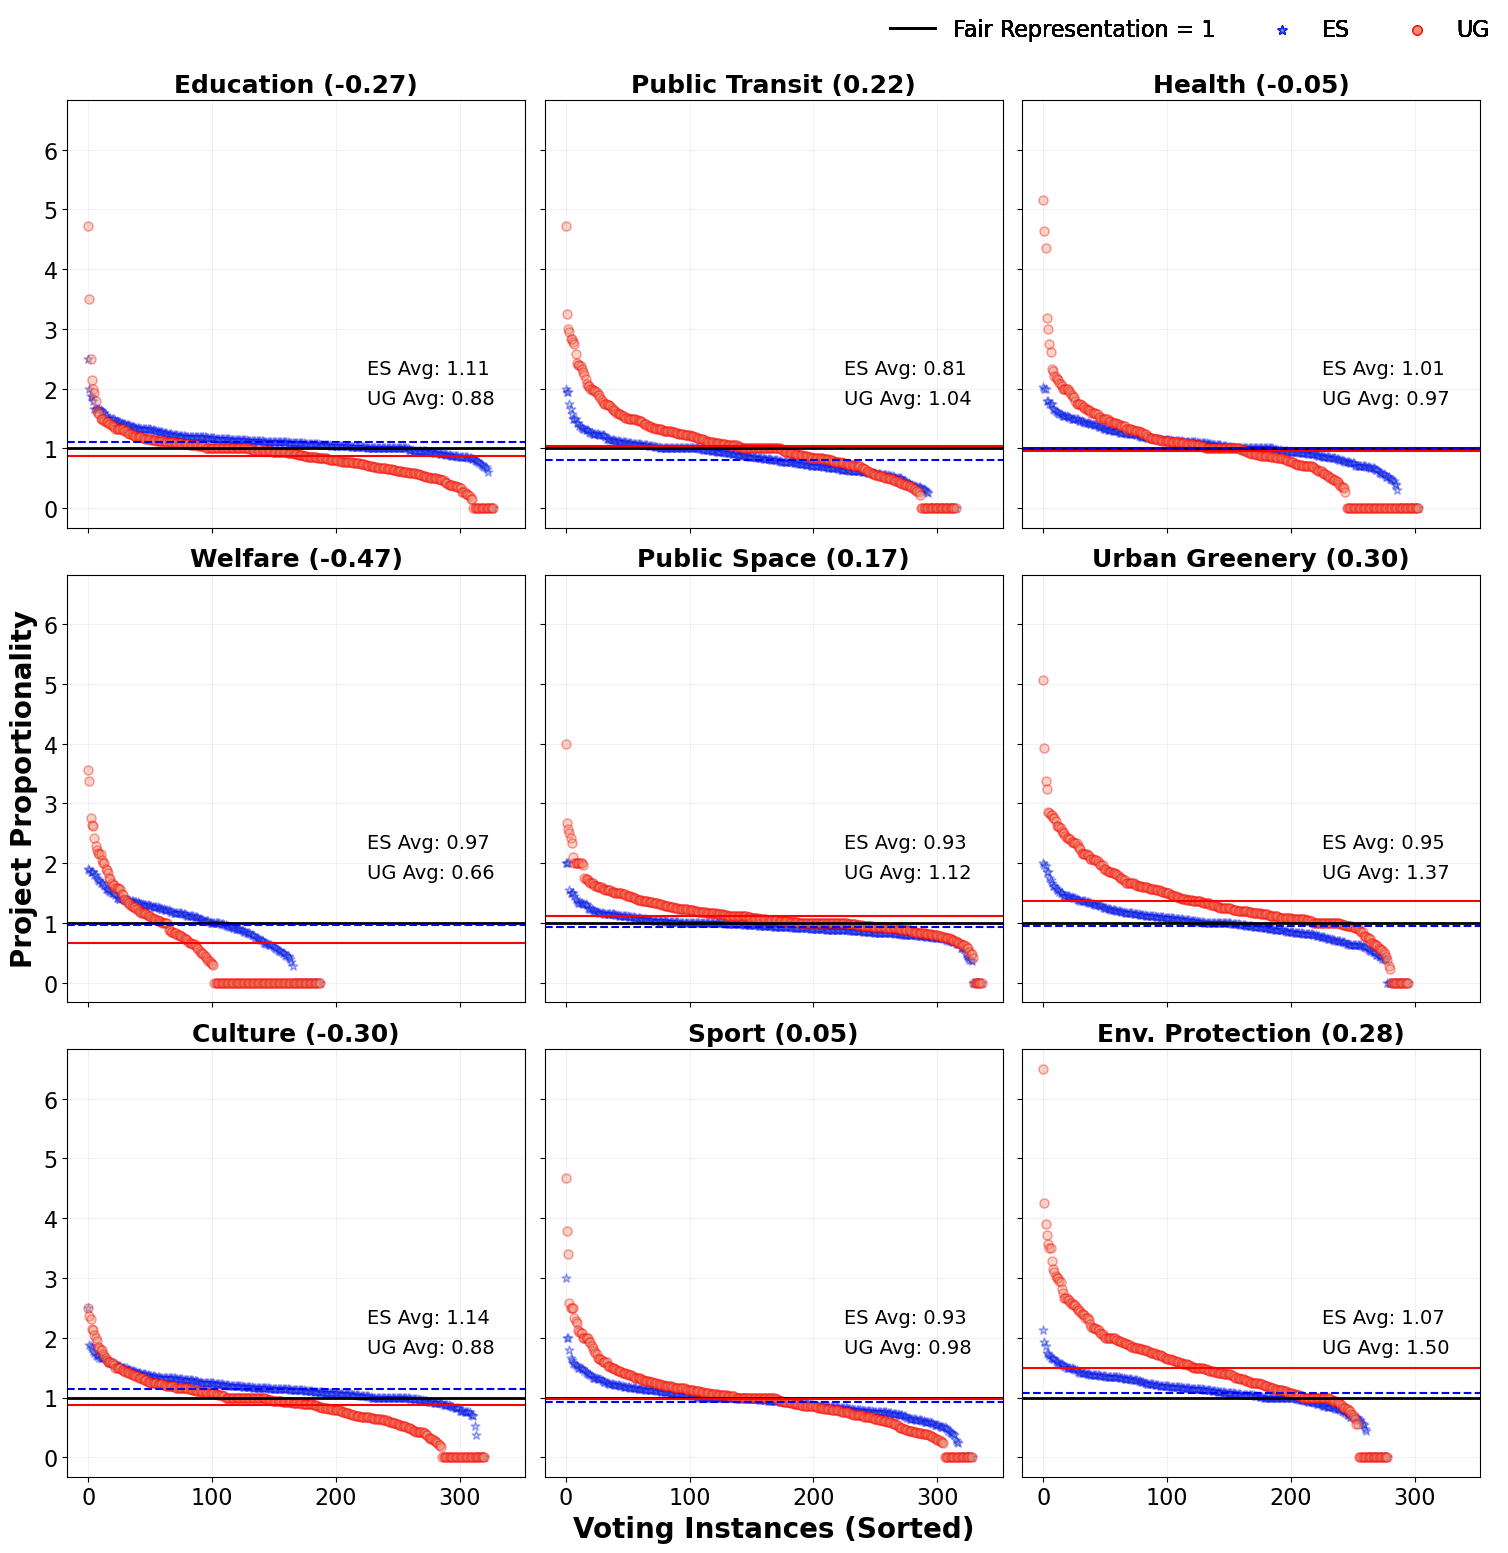

In [39]:
# project proportionality ratio; UG vs ES; project count
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

mes_heatmap_dict = {}
greedy_heatmap_dict = {}
for idx, category in enumerate(categories_set):
    [x_pos, y_pos] = oneD_to_twoD_map[idx]
    temp_df = categorization_df[['election_id', f'greedy_rr_projects_count_{category}', f'mes_rr_projects_count_{category}']]
    temp_df.drop_duplicates(inplace=True)
    
    # threshold line
    axes[x_pos][y_pos].axhline(y=1, color='black', label='Fair Representation = 1', linewidth=2)

    greedy_rr_projects_count_category = temp_df[['election_id', f'greedy_rr_projects_count_{category}']].sort_values(by=f'greedy_rr_projects_count_{category}', ascending=False).reset_index()
    greedy_rr_projects_count_category_avg = greedy_rr_projects_count_category[f'greedy_rr_projects_count_{category}'].mean()

    mes_rr_projects_count_category = temp_df[['election_id', f'mes_rr_projects_count_{category}']].sort_values(by=f'mes_rr_projects_count_{category}', ascending=False).reset_index()    
    mes_rr_projects_count_category_avg = mes_rr_projects_count_category[f'mes_rr_projects_count_{category}'].mean()

    axes[x_pos][y_pos].scatter(range(len(mes_rr_projects_count_category)), mes_rr_projects_count_category[f'mes_rr_projects_count_{category}'], label='ES', marker='*', s=42, facecolors='#72b6a1', alpha=0.4, color='blue')
    axes[x_pos][y_pos].scatter(range(len(greedy_rr_projects_count_category)), greedy_rr_projects_count_category[f'greedy_rr_projects_count_{category}'], label='UG', marker='o', s=42, facecolors='#e99675', alpha=0.4, color='red')

    # average line
    axes[x_pos][y_pos].axhline(y=greedy_rr_projects_count_category_avg, color='red', linestyle='solid')
    axes[x_pos][y_pos].axhline(y=mes_rr_projects_count_category_avg, color='blue', linestyle='dashed')

    mes_rr_projects_count_category_avg = np.nanmean(mes_rr_projects_count_category[f'mes_rr_projects_count_{category}'])
    greedy_rr_projects_count_category_avg = np.nanmean(greedy_rr_projects_count_category[f'greedy_rr_projects_count_{category}'])

    rdi = (greedy_rr_projects_count_category_avg - mes_rr_projects_count_category_avg) / (greedy_rr_projects_count_category_avg)


    axes[x_pos][y_pos].set_title(f'{category_title_map[category]} ({rdi:.2f})', fontsize=18, fontweight='bold')
    # if x_pos == 0 and y_pos == 2:
    #     axes[x_pos][y_pos].legend(handlelength=1.0, handletextpad=0.5, fontsize=14, frameon=False)

    if x_pos == 1 and y_pos == 0:
        axes[x_pos][y_pos].set_ylabel("Project Proportionality", fontsize=20, fontweight='bold')

    if x_pos == 2 and y_pos == 1:
        axes[x_pos][y_pos].set_xlabel('Voting Instances (Sorted)', fontsize=20, fontweight='bold')
    
    axes[x_pos][y_pos].tick_params(axis='both', labelsize=16)
    axes[x_pos][y_pos].grid(axis='both', which='major', color='gray', alpha=0.1)

    # annotate text for avg values
    axes[x_pos][y_pos].text(225, 2.25, f'ES Avg: {mes_rr_projects_count_category_avg:.2f}', fontsize=14)
    axes[x_pos][y_pos].text(225, 1.75, f'UG Avg: {greedy_rr_projects_count_category_avg:.2f}', fontsize=14)

    # Customize legend
    handles, labels = axes[0][0].get_legend_handles_labels()

    # Create legend outside of the main plot
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 1.04), ncols=3, frameon=False, fontsize=16)
    fig.subplots_adjust(right=1)  # Adjust right side to fit legend

plt.tight_layout()
plt.show()

## Code blocks for analysis of Green Million and City Idea Aarau

In [40]:
budget_share_cols = ['election_id']
winning_rate_cols = ['election_id']
cost_representation_cols = ['election_id']
project_representation_cols = ['election_id']

for category in categories_set:
    budget_share_cols.append(f'greedy_relative_winners_cost_pct_{category}')
    budget_share_cols.append(f'mes_relative_winners_cost_pct_{category}')
    budget_share_cols.append(f'diff_greedy_mes_relative_winners_cost_pct_{category}')

    winning_rate_cols.append(f'greedy_relative_winners_count_pct_{category}')
    winning_rate_cols.append(f'mes_relative_winners_count_pct_{category}')
    winning_rate_cols.append(f'diff_greedy_mes_relative_winners_count_pct_{category}')

    cost_representation_cols.append(f'greedy_relative_proposals_cost_pct_{category}')
    cost_representation_cols.append(f'mes_relative_proposals_cost_pct_{category}')
    cost_representation_cols.append(f'diff_greedy_mes_relative_proposals_cost_pct_{category}')

    project_representation_cols.append(f'greedy_relative_proposals_count_pct_{category}')
    project_representation_cols.append(f'mes_relative_proposals_count_pct_{category}')
    project_representation_cols.append(f'diff_greedy_mes_relative_proposals_count_pct_{category}')


budget_share_df = categorization_df[budget_share_cols]
budget_share_df.drop_duplicates(inplace=True)

winning_rate_df = categorization_df[winning_rate_cols]
winning_rate_df.drop_duplicates(inplace=True)

cost_representation_df = categorization_df[cost_representation_cols]
cost_representation_df.drop_duplicates(inplace=True)

project_representation_df = categorization_df[project_representation_cols]
project_representation_df.drop_duplicates(inplace=True)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\3294752856.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget_share_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\3294752856.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_rate_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_25492\3294752856.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co

In [41]:
avg_bs_impact = {}
sd_bs_impact = {}

avg_wr_impact = {}
sd_wr_impact = {}

avg_cr_impact = {}
sd_cr_impact = {}

avg_pr_impact = {}
sd_pr_impact = {}

zm_bs_impact = {}
zm_wr_impact = {}
zm_cr_impact = {}
zm_pr_impact = {}

aa_bs_impact = {}
aa_wr_impact = {}
aa_cr_impact = {}
aa_pr_impact = {}

for category in categories_set:
    print("Current category: ", category)
    # for budget share
    bs_diff_avg = budget_share_df[f'diff_greedy_mes_relative_winners_cost_pct_{category}'].mean()
    bs_diff_sd = budget_share_df[f'diff_greedy_mes_relative_winners_cost_pct_{category}'].std()
    avg_bs_impact[category] = round(bs_diff_avg, 3)
    sd_bs_impact[category] = round(bs_diff_sd, 3)
    
    zm_bs_diff_avg = budget_share_df[budget_share_df['election_id'] == green_budget_election_id][f'diff_greedy_mes_relative_winners_cost_pct_{category}'].mean()
    zm_bs_impact[category] = round(zm_bs_diff_avg, 3)
    aa_bs_diff_avg = budget_share_df[budget_share_df['election_id'] == aarau_election_id][f'diff_greedy_mes_relative_winners_cost_pct_{category}'].mean()
    aa_bs_impact[category] = round(aa_bs_diff_avg, 3)

    # for winning rate
    wr_diff_avg = winning_rate_df[f'diff_greedy_mes_relative_winners_count_pct_{category}'].mean()
    wr_diff_sd = winning_rate_df[f'diff_greedy_mes_relative_winners_count_pct_{category}'].std()
    avg_wr_impact[category] = round(wr_diff_avg, 3)
    sd_wr_impact[category] = round(wr_diff_sd, 3)

    zm_wr_diff_avg = winning_rate_df[winning_rate_df['election_id'] == green_budget_election_id][f'diff_greedy_mes_relative_winners_count_pct_{category}'].mean()
    zm_wr_impact[category] = round(zm_wr_diff_avg, 3)
    aa_wr_diff_avg = winning_rate_df[winning_rate_df['election_id'] == aarau_election_id][f'diff_greedy_mes_relative_winners_count_pct_{category}'].mean()
    aa_wr_impact[category] = round(aa_wr_diff_avg, 3)

    # for cost representation
    cr_diff_avg = cost_representation_df[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'].mean()
    cr_diff_sd = cost_representation_df[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'].std()
    avg_cr_impact[category] = round(cr_diff_avg, 3)
    sd_cr_impact[category] = round(cr_diff_sd, 3)

    zm_cr_diff_avg = cost_representation_df[cost_representation_df['election_id'] == green_budget_election_id][f'diff_greedy_mes_relative_proposals_cost_pct_{category}'].mean()
    zm_cr_impact[category] = round(zm_cr_diff_avg, 3)
    aa_cr_diff_avg = cost_representation_df[cost_representation_df['election_id'] == aarau_election_id][f'diff_greedy_mes_relative_proposals_cost_pct_{category}'].mean()
    aa_cr_impact[category] = round(aa_cr_diff_avg, 3)

    # for project representation
    pr_diff_avg = project_representation_df[f'diff_greedy_mes_relative_proposals_count_pct_{category}'].mean()
    pr_diff_sd = project_representation_df[f'diff_greedy_mes_relative_proposals_count_pct_{category}'].std()
    avg_pr_impact[category] = round(pr_diff_avg, 3)
    sd_pr_impact[category] = round(pr_diff_sd, 3)
    
    zm_pr_diff_avg = project_representation_df[project_representation_df['election_id'] == green_budget_election_id][f'diff_greedy_mes_relative_proposals_count_pct_{category}'].mean()
    zm_pr_impact[category] = round(zm_pr_diff_avg, 3)
    aa_pr_diff_avg = project_representation_df[project_representation_df['election_id'] == aarau_election_id][f'diff_greedy_mes_relative_proposals_count_pct_{category}'].mean()
    aa_pr_impact[category] = round(aa_pr_diff_avg, 3)

## manually fit health value for zm cr and pr to zero; because they were nan
zm_cr_impact['health'] = 0
zm_pr_impact['health'] = 0

zm_cr_impact['culture'] = 0
zm_pr_impact['culture'] = 0

aa_cr_impact['public_space'] = 0
aa_pr_impact['public_space'] = 0

print(avg_bs_impact)
print(avg_wr_impact)
print(avg_cr_impact)
print(avg_pr_impact)
print("------------------------------")
print(zm_bs_impact)
print(zm_wr_impact)
print(zm_cr_impact)
print(zm_pr_impact)
print("------------------------------")
print(aa_bs_impact)
print(aa_wr_impact)
print(aa_cr_impact)
print(aa_pr_impact)

Current category:  education
Current category:  public_transit_and_roads
Current category:  health
Current category:  welfare
Current category:  public_space
Current category:  urban_greenery
Current category:  culture
Current category:  sport
Current category:  env_protection
{'education': -0.097, 'public_transit_and_roads': 0.05, 'health': 0.011, 'welfare': -0.023, 'public_space': 0.071, 'urban_greenery': 0.057, 'culture': -0.083, 'sport': 0.051, 'env_protection': 0.042}
{'education': -0.089, 'public_transit_and_roads': 0.029, 'health': 0.004, 'welfare': -0.018, 'public_space': 0.074, 'urban_greenery': 0.069, 'culture': -0.066, 'sport': 0.011, 'env_protection': 0.058}
{'education': -0.146, 'public_transit_and_roads': 0.057, 'health': -0.107, 'welfare': -0.254, 'public_space': 0.054, 'urban_greenery': 0.066, 'culture': -0.203, 'sport': 0.019, 'env_protection': 0.019}
{'education': -0.313, 'public_transit_and_roads': -0.089, 'health': -0.235, 'welfare': -0.371, 'public_space': -0.121, 

In [42]:
# For mapping of labels
cmap = {
    'education': 'Education',
    'public_transit_and_roads': 'Public\nTransit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public\nSpace',
    'urban_greenery': 'Urban\nGreenery',
    'culture': 'Culture',
    'sport': 'Sport',
    'env_protection': 'Environmental\nProtection'
}
xlabells = []

for k, v in avg_bs_impact.items():
    print(k)
    xlabells.append(cmap[k])

education
public_transit_and_roads
health
welfare
public_space
urban_greenery
culture
sport
env_protection


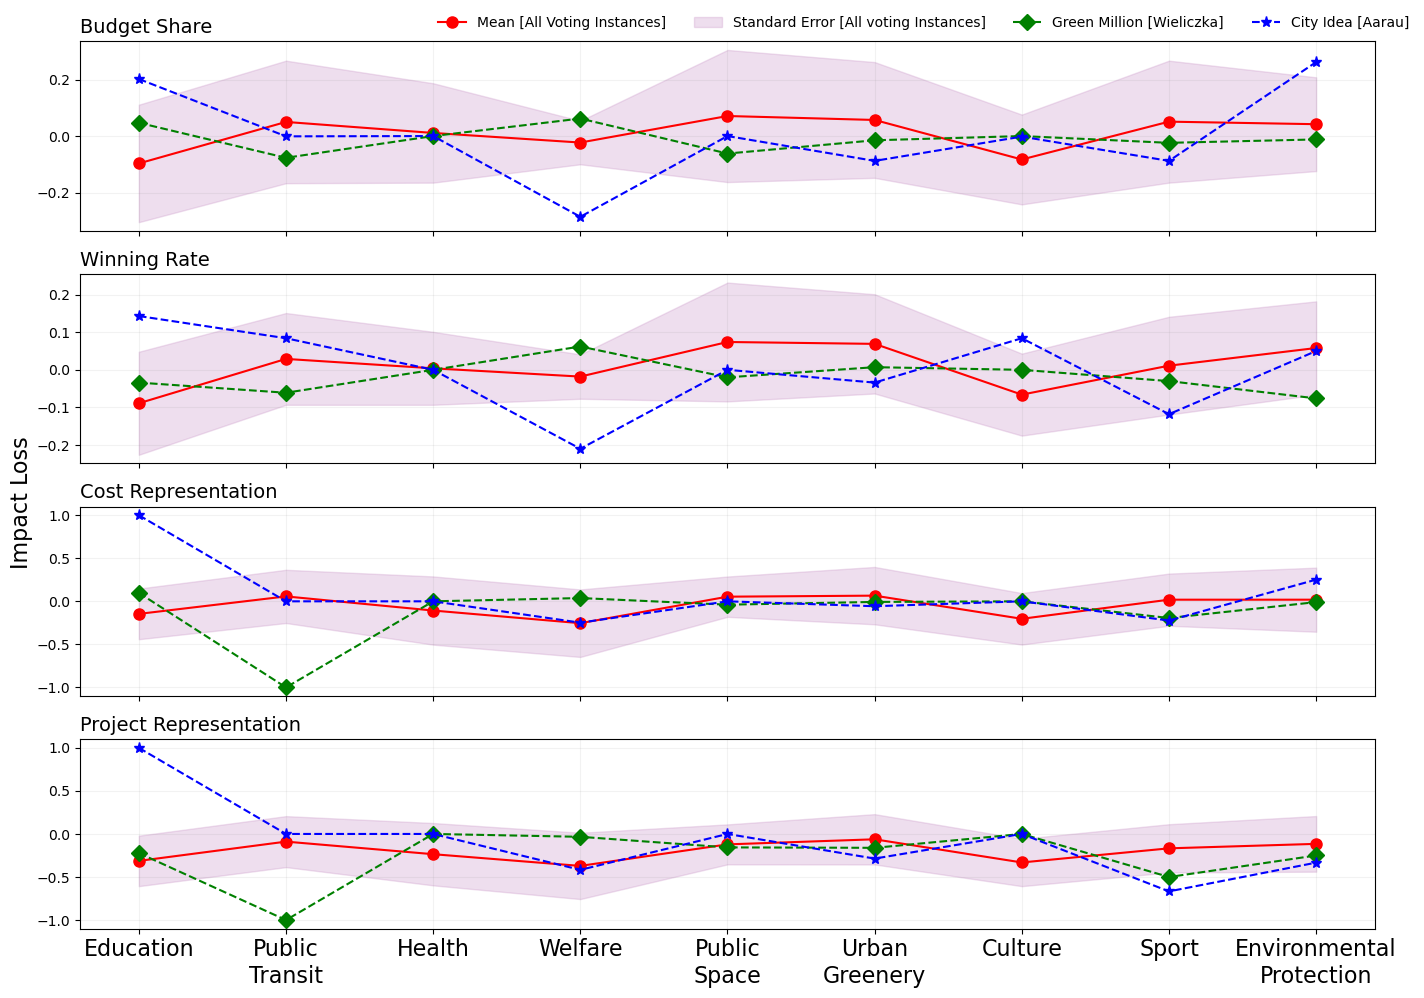

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

avg_bs_values = [v for _, v in avg_bs_impact.items()]
avg_bs_values = np.array(avg_bs_values)
sd_bs_values = [v for v in sd_bs_impact.values()]
sd_bs_values = np.array(sd_bs_values)
zm_bs_values = [v for _, v in zm_bs_impact.items()]
aa_bs_values = [v for _, v in aa_bs_impact.items()]

avg_wr_values = [v for v in avg_wr_impact.values()]
avg_wr_values = np.array(avg_wr_values)
sd_wr_values = [v for v in sd_wr_impact.values()]
sd_wr_values = np.array(sd_wr_values)
zm_wr_values = [v for v in zm_wr_impact.values()]
aa_wr_values = [v for v in aa_wr_impact.values()]

avg_cr_values = [v for v in avg_cr_impact.values()]
avg_cr_values = np.array(avg_cr_values)
sd_cr_values = [v for v in sd_cr_impact.values()]
sd_cr_values = np.array(sd_cr_values)
zm_cr_values = [v for v in zm_cr_impact.values()]
aa_cr_values = [v for v in aa_cr_impact.values()]

avg_pr_values = [v for v in avg_pr_impact.values()]
avg_pr_values = np.array(avg_pr_values)
sd_pr_values = [v for v in sd_pr_impact.values()]
sd_pr_values = np.array(sd_pr_values)
zm_pr_values = [v for v in zm_pr_impact.values()]
aa_pr_values = [v for v in aa_pr_impact.values()]

axes[0].plot(range(len(avg_bs_values)), avg_bs_values, color='r', label='Mean [All Voting Instances]', marker='o', markersize=8)
axes[0].fill_between(range(len(avg_bs_values)), avg_bs_values - sd_bs_values, avg_bs_values + sd_bs_values, color='#c994c7', alpha=0.3, label='Standard Error [All voting Instances]')
axes[0].plot(range(len(zm_bs_values)), zm_bs_values, color='g', label='Green Million [Wieliczka]', marker='D', markersize=8, linestyle='--')
axes[0].plot(range(len(aa_bs_values)), aa_bs_values, color='b', label='City Idea [Aarau]', marker='*', markersize=8, linestyle='--')
axes[0].set_title('Budget Share', loc='left', fontsize=14)
axes[0].grid(axis='both', which='major', color='gray', alpha=0.1)


axes[1].plot(range(len(avg_wr_values)), avg_wr_values, color='r', label='Overall', marker='o', markersize=8)
axes[1].fill_between(range(len(avg_wr_values)), avg_wr_values - sd_wr_values, avg_wr_values + sd_wr_values, color='#c994c7', alpha=0.3)
axes[1].plot(range(len(zm_wr_values)), zm_wr_values, color='g', label='Zielony Milion', marker='D', markersize=8, linestyle='--')
axes[1].plot(range(len(aa_wr_values)), aa_wr_values, color='b', label='Stadt Aaarau', marker='*', markersize=8, linestyle='--')
axes[1].set_title('Winning Rate', loc='left', fontsize=14)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.1)

axes[2].plot(range(len(avg_cr_values)), avg_cr_values, color='r', label='Overall', marker='o', markersize=8)
axes[2].fill_between(range(len(avg_cr_values)), avg_cr_values - sd_cr_values, avg_cr_values + sd_cr_values, color='#c994c7', alpha=0.3)
axes[2].plot(range(len(zm_cr_values)), zm_cr_values, color='g', label='Zielony Milion', marker='D', markersize=8, linestyle='--')
axes[2].plot(range(len(aa_cr_values)), aa_cr_values, color='b', label='Stadt Aaarau', marker='*', markersize=8, linestyle='--')
axes[2].set_title('Cost Representation', loc='left', fontsize=14)
axes[2].grid(axis='both', which='major', color='gray', alpha=0.1)

axes[3].plot(range(len(avg_pr_values)), avg_pr_values, color='r', label='Overall', marker='o', markersize=8)
axes[3].fill_between(range(len(avg_pr_values)), avg_pr_values - sd_pr_values, avg_pr_values + sd_pr_values, color='#c994c7', alpha=0.3)
axes[3].plot(range(len(zm_pr_values)), zm_pr_values, color='g', label='Zielony Milion', marker='D', markersize=8, linestyle='--')
axes[3].plot(range(len(aa_pr_values)), aa_pr_values, color='b', label='Stadt Aaarau', marker='*', markersize=8, linestyle='--')
axes[3].set_title('Project Representation', loc='left', fontsize=14)
axes[3].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[3].set_xticks(range(len(avg_pr_values)))
axes[3].set_xticklabels(xlabells)

# Customize legend
handles, labels = axes[0].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0), ncols=5, frameon=False, fontsize=10)


fig.text(0, 0.5, 'Impact Loss', ha='center', va='center', rotation='vertical', fontsize=16)

plt.xticks(fontsize=16)
plt.tight_layout()
plt.show()